# Data100 Final Project
Yue Hu, Xintong Jiang, Anqi Shi
## Problem Statement
Diabetic Retinopathy (DR) is a fastest growing cause of disease.


**What is Diabetic Retinopathy (DR)?**

People with diabetes can have an eye disease called diabetic retinopathy. This is when high blood sugar levels cause damage to blood vessels in the retina. These blood vessels can swell and leak. Or they can close, stopping blood from passing through. Sometimes abnormal new blood vessels grow on the retina. All of these changes can cause vision problem.
This disease has five stages.
The labels are distinguished as below:

0 - Normal

1 - Mild DR

2 - Moderate DR

3 - Severe DR

4 - Proliferative diabetic retinopathy (PDR)

Especisally, it's difficult to diagnose the middle stages by eyes. Even when doctors are available, the eye exam results are graded inconsistent and surprisingly variable. So we hope to use machine learning methods to classify the stages correctly.

## Data Preprocessing


### Data Description

The data we used are labeled retina images of patients from 5 different DR stages, which are provided by Kaggle. We have 1500 images in total.




In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array 
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import ImageFile

Using TensorFlow backend.


### Loading and Cleaning Data

Now we load our image data and labels from google drive.

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/fintech_DR/images"

os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
imageList = os.listdir(path)
imageList_clean=[]
for i in range(len(imageList)):
  if imageList[i][-4:] == 'jpeg':
    imageList_clean.append(imageList[i])
  else:
    print(imageList[i])
image=[]
for i in range(len(imageList_clean)):
    image.append(Image.open(path+'/'+imageList_clean[i]))

In [0]:
# read labels from google drive
import json
with open(r'/content/gdrive/My Drive/fintech_DR/labels.json') as path:
    labels = json.load(path)

#df_train = pd.DataFrame(labels)
#df_train[0] = df_train[0].apply(lambda x: x.replace(".jpeg",""))
#df_train = df_train.rename(columns = {0:'image',1:"level"})

In [0]:
# pair the image with our labels
labeldict=dict(labels)
dataset=pd.DataFrame()
dataset['index']=imageList_clean[0:1500]
dataset['label']=dataset['index'].map(labeldict)
dataset.head()

,index,label
0,13962_right.jpeg,1
1,31186_left.jpeg,0
2,3513_left.jpeg,0
3,24450_left.jpeg,0
4,2191_right.jpeg,0


### EDA

#### Image Display

First, we plot out the image of eyeballs from different stages to check the quality of our loaded images.

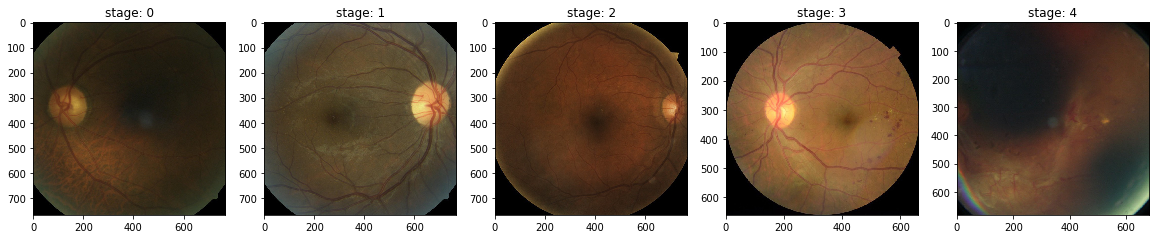

In [0]:
plt.figure(figsize = (20,20))
image_list = [1,0,13,376,71]
for i in range(len(image_list)):
  plt.subplot(1,5,i+1)
  imgplot = plt.imshow(image[image_list[i]])
  plt.title("stage: " + str(i))
plt.show()

From the above plot, we clearly oberserve there is no much difference between the retina plot from distinct stages. So it is necessary for us to use machine learning method to classify the plot.

#### Data Distribution

Next, we take a look at the distribution of the labels. From the graph below, it can be seen that the distribution of labels is imbalanced. We only have 21 images labeled stage 4 while we have 1095 images labeled stage 0.

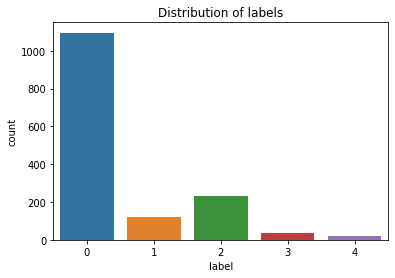

In [0]:
import seaborn as sns
sns.countplot(x = 'label', data  = dataset)
plt.title("Distribution of labels")
plt.show()

In [0]:
dataset['label'].value_counts()

0    1095
2     229
1     120
3      35
4      21
Name: label, dtype: int64

### Pre Processing

#### Enhance image quality

In [0]:
from PIL import ImageEnhance
image_en=[]
for i in range(len(image)):
  contrast_enhancer = ImageEnhance.Contrast(image[i])
  eye_enhanced_image = contrast_enhancer.enhance(2)
  enhanced_image = np.asarray(eye_enhanced_image)
  b,g,r  = cv2.split(enhanced_image)
  enhanced_image = cv2.merge([b, g, r])
  image_en.append(enhanced_image)

Now we display the same plot as above after enhancement.

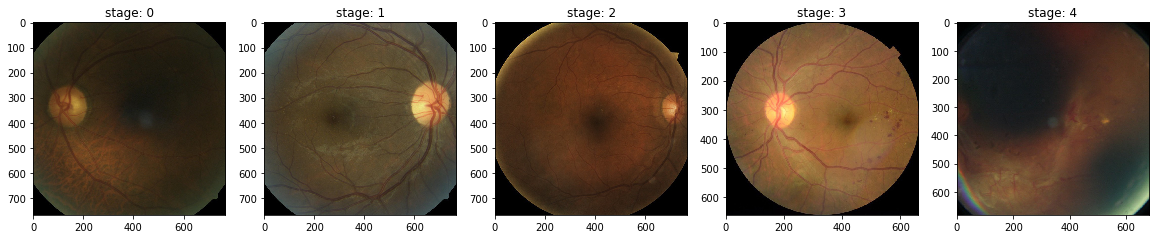

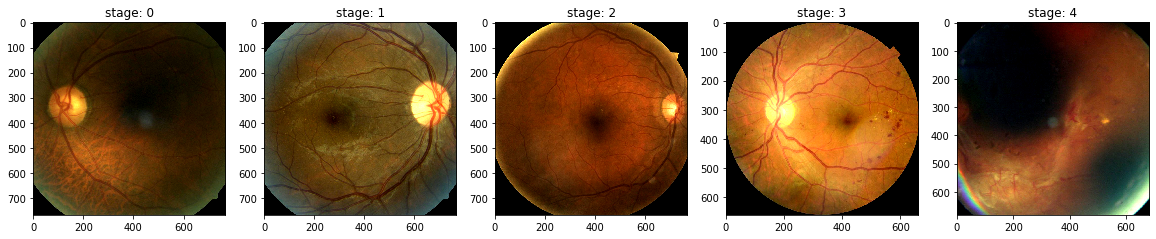

In [0]:
# original image
plt.figure(figsize = (20,20))
image_list = [1,0,13,376,71]
for i in range(len(image_list)):
  plt.subplot(1,5,i+1)
  imgplot = plt.imshow(image[image_list[i]])
  plt.title("stage: " + str(i))
plt.show()

# enhanced image
plt.figure(figsize = (20,20))
for i in range(len(image_list)):
  plt.subplot(1,5,i+1)
  imgplot = plt.imshow(image_en[image_list[i]])
  plt.title("stage: " + str(i))
plt.show()


### Resize the image
Because currently our images are of different size, we resize our data to the same size.

In [0]:
# convert the image to array.
I_array=[]
for im in image_en:
    I_array.append(np.array(im))

# resize our image
for i in range(len(I_array)):
    I_array[i] = cv2.resize((I_array[i]), (512,512), interpolation=cv2.INTER_CUBIC)

### Gray Analysis
To make the computation less demanding and keep the main features of the retina image, we turn these images into gray.

In [0]:
immatrix=[]
for i in range(len(I_array)):
    img_gray = cv2.cvtColor(I_array[i], cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(img_gray) 
    immatrix.append(np.array(equ).flatten())

Now we show the new images and compare it with our enhanced data.

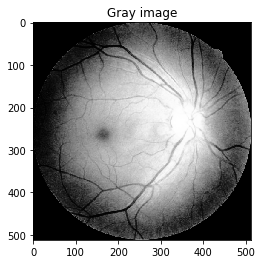

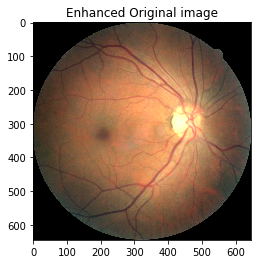

In [0]:
# gray image
plt.imshow(immatrix[235].reshape((512,512)),cmap='gray')
plt.title('Gray image')
plt.show()

# enhanced image
plt.figure()
imgplot = plt.imshow(image_en[235])
plt.title('Enhanced Original image')
plt.show()

### PCA
As could be seen above, now we have total features of 512*512 (262144). To reduce the dimension of our data without losing critical information, we conduct principal compoment analysis (PCA) on our features. 

In [0]:
x_train = pd.DataFrame(np.matrix(immatrix))

In [0]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,262104,262105,262106,262107,262108,262109,262110,262111,262112,262113,262114,262115,262116,262117,262118,262119,262120,262121,262122,262123,262124,262125,262126,262127,262128,262129,262130,262131,262132,262133,262134,262135,262136,262137,262138,262139,262140,262141,262142,262143
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from sklearn.decomposition import PCA
import time

n = 300
t0 = time.time()
pca = PCA(n_components=n, whiten=True).fit(x_train)
print("pca done %0.3fs" % (time.time() - t0))

print(sum(pca.explained_variance_ratio_))

t0 = time.time()
x_train_pca = pca.transform(x_train)
print("data set to pca done %0.3fs" % (time.time() - t0))

pca done 72.548s
0.9402963065550466
data set to pca done 5.284s


### Split data

Now we split the data into training and testing set.

In [0]:
from sklearn.model_selection import train_test_split
y_train = dataset['label']
X_train_pca, X_test_pca, y_train, y_test = train_test_split(x_train_pca, y_train, test_size = 0.2, random_state=42)

## Building model
Now we building models using the pca trainning data.

### Logistic Regression
Since this a multi-classification problem, we set logistic_regression_model to be a one-vs-rest logistic regression model. 

In [0]:
# We add L1 regularization in logistic regression to reduce overfitting
from sklearn.linear_model import LogisticRegression
logistic_regression_model =  LogisticRegression(multi_class = 'ovr', penalty='l1').fit(X_train_pca,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
lr_training_accuracy = logistic_regression_model.score(X_train_pca, y_train)
lr_test_accuracy = logistic_regression_model.score(X_test_pca, y_test)
print("Training Accuracy: ", lr_training_accuracy)
print("Testing Accuracy: ", lr_test_accuracy)

Training Accuracy:  0.8391666666666666
Testing Accuracy:  0.65


The training accuracy of the logistic regression model is 83.25%, while the testing accuracy is only around 65.33%. The performance is not so good, so now we will try more advanced models.

Here we display the confusion matrix of our model.

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, logistic_regression_model.predict(X_test_pca))

array([[192,  16,  13,   2,   0],
       [ 16,   1,   1,   0,   0],
       [ 33,   4,   3,   1,   1],
       [ 11,   0,   1,   0,   0],
       [  5,   0,   0,   0,   0]])

### Cross-validated Random Forest


To avoid overfitting, here we use 5-fold cross validation to choose the best parameters for the random forest model. We cross validated parameters such as n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf and bootstrap.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 15,16,17,18,19,20]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['sqrt', 15, 16, 17, 18, 19, 20],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134, 150]}


In [0]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train_pca, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 19,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 134}

In [0]:
best_rf = rf_random.best_estimator_

In [0]:
print("Train Score: ", round(best_rf.score(X_train_pca,y_train),4))
print("Test Score: ", round(best_rf.score(X_test_pca,y_test),4))

Train Score:  0.8092
Test Score:  0.7433


The training accuracy of the random forest model is 89.42%, while the testing accuracy is 74%.

Next we display the confusion matrix of our random forest model.

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, best_rf.predict(X_test_pca))

array([[223,   0,   0,   0,   0],
       [ 18,   0,   0,   0,   0],
       [ 42,   0,   0,   0,   0],
       [ 12,   0,   0,   0,   0],
       [  5,   0,   0,   0,   0]])

From the confusion matrix above, we see that our random forest model predict all the test data to be 0, which has no significant difference with baseline model. The random forest model is not so good.

### SVM


In [0]:
#### training svm model

from sklearn import svm
from sklearn.model_selection import GridSearchCV

# classifier
t0 = time.time()
params = {
    "C": [0.001,0.01,1,10,100],
    "gamma": [0.001,0.01,1,10,100]
}

#{1: 10000}

clf = GridSearchCV(svm.SVC(kernel='linear', class_weight = 'balanced'), param_grid = params)
clf.fit(X_train_pca, y_train)
print("fit done %0.3fs" % (time.time() - t0))
print(clf.best_estimator_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


fit done 49.882s
SVC(C=0.001, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [0]:
#### predict through svm model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


t0 = time.time()
pred_svm = clf.predict(X_test_pca)
names = ["0","1","2","3","4"]
print(classification_report(y_test, pred_svm, target_names = names))
print(confusion_matrix(y_test, pred_svm, labels=[0,1,2,3,4]))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       223
           1       0.03      0.06      0.04        18
           2       0.16      0.10      0.12        42
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         5

    accuracy                           0.58       300
   macro avg       0.19      0.18      0.18       300
weighted avg       0.58      0.58      0.58       300

[[170  26  19   2   6]
 [ 15   1   1   1   0]
 [ 29   4   4   1   4]
 [ 10   1   1   0   0]
 [  5   0   0   0   0]]


### Convolutional Neural Network (CNN)

To solve the imbalance problem, we used data augmentation to increase the size of data in minority classes.

In [0]:
from sklearn.model_selection import train_test_split
y_train = dataset['label']
X_train_pca, X_test_pca, y_train, y_test = train_test_split(x_train_pca, y_train, test_size = 0.2, random_state=42)

In [0]:
#visible = Input(shape=(512,512,1))
visible = Input(shape = (300,))
'''
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(visible)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
bat1 = BatchNormalization()(conv2)
zero1 = ZeroPadding2D(padding=(1, 1))(bat1)

conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(zero1)
conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(conv3)
bat2 = BatchNormalization()(conv4)
pool2 = MaxPooling2D(pool_size=(2, 2))(bat2)

conv5 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(pool2)
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv5)
bat3 = BatchNormalization()(conv6)
pool3 = MaxPooling2D(pool_size=(2, 2))(bat3)
zero2 = ZeroPadding2D(padding=(1, 1))(pool3)

conv7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(zero2)
conv8 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv7)
bat4 = BatchNormalization()(conv8)

conv9 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(bat4)
conv10 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv9)
bat5 = BatchNormalization()(conv10)

conv11 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(bat5)
conv12 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv11)
bat6 = BatchNormalization()(conv12)
pool4 = MaxPooling2D(pool_size=(2, 2))(bat6)

conv13 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(pool4)
conv14 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv13)
bat7 = BatchNormalization()(conv14)

conv15 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(bat7)
conv16 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv15)
bat8 = BatchNormalization()(conv16)

flat = Flatten()(bat8)
'''
hidden1 = Dense(32, activation='relu')(visible)
drop1 = Dropout(0.3)(hidden1)

hidden2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)

hidden3 = Dense(64, activation='relu')(drop2)

hidden4 = Dense(128, activation='relu')(hidden3)

drop3 = Dropout(0.05)(hidden4)

hidden5 = Dense(128, activation='relu')(drop3)
drop4 = Dropout(0.1)(hidden5)

output = Dense(5, activation='sigmoid')(drop4)


model = Model(inputs=visible, outputs=output)

In [0]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                9632      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               8320

In [0]:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


In [0]:
model.compile(optimizer= opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
Callbacks=[EarlyStopping(patience=5000, restore_best_weights=True), 
           ReduceLROnPlateau(patience=5000), 
           ModelCheckpoint(filepath='ImageDataGen_Size256_gray_Callbacks_SGD_L2.h5', save_best_only=True)]

In [0]:
m1= model.fit(X_train_pca, keras.utils.to_categorical(y_train),batch_size=32, epochs=3000, validation_split = 0.1,
            callbacks=Callbacks,
            verbose=1)

Train on 1080 samples, validate on 120 samples
Epoch 1/3000
1080/1080 [==============================] - 0s 147us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 1.8377 - val_acc: 0.8767
Epoch 2/3000
1080/1080 [==============================] - 0s 151us/step - loss: 6.2238e-04 - acc: 1.0000 - val_loss: 1.8378 - val_acc: 0.8767
Epoch 3/3000
1080/1080 [==============================] - 0s 143us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 1.8387 - val_acc: 0.8767
Epoch 4/3000
1080/1080 [==============================] - 0s 143us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 1.8390 - val_acc: 0.8767
Epoch 5/3000
1080/1080 [==============================] - 0s 139us/step - loss: 0.0055 - acc: 0.9989 - val_loss: 1.8398 - val_acc: 0.8767
Epoch 6/3000
1080/1080 [==============================] - 0s 135us/step - loss: 0.0035 - acc: 0.9993 - val_loss: 1.8400 - val_acc: 0.8767
Epoch 7/3000
1080/1080 [==============================] - 0s 136us/step - loss: 0.0039 - acc: 0.9989 - val_loss: 1.8427 -

In [0]:
y_pred = model.predict(X_test_pca)

In [0]:
pred_labels=np.argmax(y_pred, axis=1)


In [0]:
np.array(pred_labels)
sum(np.array(y_test) == pred_labels)/ len(pred_labels)


0.7366666666666667

In [0]:

from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, pred_labels)

array([[220,   1,   2,   0,   0],
       [ 18,   0,   0,   0,   0],
       [ 41,   0,   1,   0,   0],
       [ 12,   0,   0,   0,   0],
       [  5,   0,   0,   0,   0]])